**What is Telecom Churn?**
<br />
The churn metric is mostly shown as the percentage of customers that cancel a product or service within a given period (mostly months). If a Telco company had 10 Mio. customers on the 1st of January and received 500K contract terminations until the 31st of January the monthly churn for January would be 5%

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install miceforest
import miceforest as mf
import warnings
warnings.filterwarnings('ignore')

## Importing The Data

In [ ]:
pd.set_option('max_colwidth', 400)
pd.set_option("display.max_columns", 400)
pd.set_option("display.max_rows", 400)
train=pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c35/train (1).csv")
test=pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c35/test (1).csv")
data_dictionary=pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c35/data_dictionary (1).csv")
sample=pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c35/sample (2).csv")

In [ ]:
train.head()
print(train.shape)

In [ ]:
data_dictionary

In [ ]:
pd.DataFrame(train.dtypes).reset_index()[0].unique()

# Data Understanding, Preparation, and Pre-Processing

In [ ]:
train.select_dtypes(include='object').head(1)

In [ ]:
train.select_dtypes(include='int64').head(1)

In [ ]:
train.select_dtypes(include='float').head(1)

# **Imputing Missing Values**

In data analytics, missing data is a factor that degrades performance. Incorrect imputation of missing values could lead to a wrong prediction. In this era of big data, when a massive volume of data is generated in every second, and utilization of these data is a major concern to the stakeholders, efficiently handling missing values becomes more important. Let's apply Imputation on the above data.

In [ ]:
missingdf=(round(train.isnull().sum()*100/train.shape[0],2)).to_frame('MissingValues').sort_values('MissingValues',ascending=False)
missingdf

**if there is a larger number of missing values, then it can be better to drop those cases (rather than do imputation) and replace them.Because if we impute those missing values it will adversely affect the performance and accuracy of any machine learning algorithm**

In [ ]:
dropNull=list(missingdf[missingdf["MissingValues"]>25].index)

In [ ]:
dropNull

In [ ]:
cleandf=train.copy()

In [ ]:
cleandf.drop(dropNull,axis=1,inplace=True)

In [ ]:
missingdf=(round(cleandf.isnull().sum()*100/train.shape[0],2)).to_frame('MissingValues').sort_values('MissingValues',ascending=False)
missingdf[~(missingdf['MissingValues']==0)]

As above observation we have only 1 value for column 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8' hence they are not adding any significance to our value, Hence we can remove these columns along with 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8','id','circle_id'

In [ ]:
cleandf.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8','last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',"circle_id","id"],axis=1,inplace=True)

In [ ]:
missingdf=(round(cleandf.isnull().sum()*100/train.shape[0],2)).to_frame('MissingValues').sort_values('MissingValues',ascending=False)
missingdf[~(missingdf['MissingValues']==0)]

Now our next step will be Estimate missing values using **Multiple Imputation by Chained Equations (MICE)**
<br />
**The MICE Algorithm**
<br />
[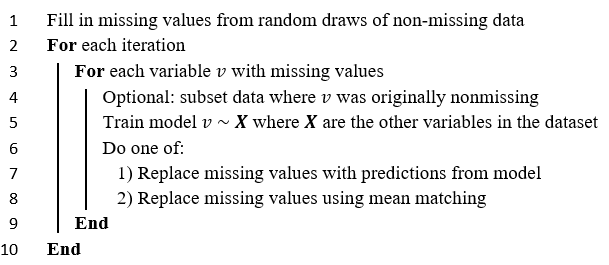

In [ ]:
##MICE Takes time to run, so we need to use GPU or TPU for fast processing
cleanimp=mf.ampute_data(cleandf,perc=0.25,random_state=1991)

In [ ]:
# Create kernels.
kernel = mf.ImputationKernel(data=cleanimp,datasets=1,save_all_iterations=True,random_state=1991)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=True)

**Saving All Kernel Impute Dataset**

In [ ]:
dataset_0 = kernel.complete_data(dataset=0, inplace=False)

In [ ]:
dataset_0.to_csv("/kaggle/working/dataset_0.csv")

In [ ]:
missingdf=(round(dataset_0.isnull().sum()*100/train.shape[0],2)).to_frame('MissingValues').sort_values('MissingValues',ascending=False)
missingdf[~(missingdf['MissingValues']==0)]

**We can see above that after applying MICE algoithm we have no null values are present in the dataset.**
<br />


# Exploratory Data Analysis 

# **Correlation**

lets check the correlation amongst the features and drop the highly correlated ones

In [ ]:
cor = dataset_0.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.80) | (cor < -0.80)].sort_values()

**From above summary we observe that:** <br />
* total_recharge amount are hightly correlated with average revenue per user based on same month 
* local incoming calls mou and total incoming calls mou are highly correlated
* ISD outgoing call mou are hightly correlated with each other
* All kind of calls within the same operator network are highly correlated with std Outgoing calls within same operator mobile to mobile
* total outgoing minutes of user are highly correlated with calls outside the calling circle(std) 
* std incoming calls are highly correlated to Operator T to other operator mobile
* total incoming minutes of user are highly corelated with each other on month on month basis
* All kind of calls outside the operator T network are highly correlated with std Operator T to T ie within same operator mobile to mobile
* Local calls within same telecom circle are highly coreleated with each other on month on month basis

**Let's Drop Highly Corelated Columns**

In [ ]:
edadf=dataset_0.copy()
edadf.drop(['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8',
'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
'total_og_mou_7','total_og_mou_8','total_og_mou_6',
'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
'loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',
'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
'total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_7',
'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8',
'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8',
'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8',
'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
'sachet_2g_6','sachet_2g_7','sachet_2g_8',
'std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8'],axis=1,inplace=True)

     

In [ ]:
plt.figure(figsize = (30,20))        # Size of the figure
sns.heatmap(edadf.corr(),annot = True)

In [ ]:
edadf.shape

Now we have 86 features, Next step is to find the relationship between churn probablity and other feature using scatter plot

In [ ]:
sns.pairplot(edadf, x_vars=edadf.drop('churn_probability', axis=1).columns, y_vars='churn_probability', size=5, aspect=0.5,kind='scatter')

For the fast processig i have set the size of the plot to 5, if we zoom this plot we found that we have outliers present inside the data, so let's remove the outliers.

# Feature Engineering and Variable Transformation

**Automatic Outlier Detection Isolation Forest**
<br />
Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.
It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space, Let's apply Isolation Forest Algorithm for outlier treatmet
>  our proposed method takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances. 
— Isolation Forest, 2008.

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
X = edadf.drop("churn_probability", axis = 1)
y = edadf.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [114]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

Once identified, we can remove the outliers from the training dataset.

In [124]:
mask=y!=-1
X_train, y_train = X_train[mask], y_train[mask]

In [126]:
print(X_train.shape,y_train.shape)

**Principal component analysis**

An unsupervised learning algorithm that is used for the dimensionality reduction in machine learning

In [127]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [128]:
pca.fit(X_train)

Lets Visualise the distibutions of columns in PCA in 2d space

In [130]:
pca.fit(X_train)
fig = plt.figure(figsize = (10,10))
plt.scatter(pca.components_[0],pca.components_[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(X_train.columns):
    plt.annotate(txt, (pca.components_[0][i],pca.components_[1][i]))
plt.tight_layout()
plt.show()

In [131]:
fig = plt.figure(figsize = (8,2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

From the visualisation we can see that around 30 components convey more than 95% data, So let's choose 30 as n_component

In [132]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=30)

In [133]:
pcaDF=pca_final.fit_transform(X_train)

In [134]:
pcaDF.shape

In [135]:
df_test_pca = pca_final.fit_transform(X_test)
df_test_pca.shape

# Model Selection, Model Building, and  Prediction 

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

**Logistic Regression**

In [140]:

steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=30)),
         ("logistic", LogisticRegression(class_weight='balanced'))]

In [142]:
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)

In [143]:
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

**Hyperparameter tuning - PCA and Logistic Regression**

In [167]:
pca = PCA()
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

pca_logistic = Pipeline(steps)

params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


In [148]:
model.fit(X_train, y_train)

In [149]:
# cross validation results
pd.DataFrame(model.cv_results_).head(10)

In [150]:
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

In [151]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

# Random Forest

In [159]:
rfc =  RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

In [161]:
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
model = GridSearchCV(estimator=rfc, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [164]:
model.fit(X_train, y_train)

In [165]:
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

In [166]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

**In above Confusion Matrix we can observe that Random Forest is overfitting on the data and sensitivity is too low. So choosing Random Forest is not a good option.The best model is PCA along with Logistic Regression** 

# Choosing Best Feature

In [170]:
max_features = int(round(np.sqrt(X_train.shape[1]))) 

In [172]:
rf_model = RandomForestClassifier(n_estimators=100,max_features=max_features, 
                                  class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)
rf_model.fit(X_train, y_train)

In [173]:
rf_model.oob_score_

In [174]:
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

**Important Feature Extraction**

In [177]:
features = edadf.drop('churn_probability', axis=1).columns

importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

In [225]:
top_train=X_train[feature_importance['variables'].head(15).tolist()]
top_test=X_test[feature_importance['variables'].head(15).tolist()]

In [226]:
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]


logistic = Pipeline(steps)

params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}


folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [227]:
model.fit(top_train, y_train)

In [228]:
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

In [229]:
import joblib 
joblib.dump(model, '/kaggle/working/final_model.pkl')

In [230]:
load_model= joblib.load('/kaggle/working/final_model.pkl')

In [231]:
predict_y = load_model.predict(top_test)

In [232]:
matrix = confusion_matrix(y_test,predict_y)
print(matrix)
sensitivity_load, specificity_load, _ = sensitivity_specificity_support(y_test, predict_y, average='binary')
print("Sensitivity: \t", round(sensitivity_load, 2), "\n", "Specificity: \t", round(specificity_load, 2), sep='')

# check area under curve
y_prob_load = load_model.predict_proba(top_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_prob_load),2))

**Loading TestSet data and Handling missing values on important features on testdata**

In [270]:
test

In [284]:
test_data=test[feature_importance['variables'].head(15).tolist()]
test_data.fillna('0',inplace=True)

In [285]:
test['churn_probability']=load_model.predict(test_data)

**Prediction output for test.csv**

In [286]:
test[['id','churn_probability']].to_csv('/kaggle/working/prediction.csv',index=False)

**Insights**
* Company needs to pay attention on Roaming Incoming and Roaming Outgoing Offers
* Need to focus on operator T to other operator mobile offers
* Need to focus on Operator T to T  within same operator mobile to mobile recharge offers

**Future Work**
* We can explore other imputation technique like SICE for the same data
* We can explore other outliers techniques like Local Outlier Factor
* We can use Lasso Regression for finding important feature 
